In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
import xarray as xr 

from include.neural_net import NeuralNet

In [101]:
weathermob_data = torch.from_numpy(pd.read_csv("../../data/Covid_mob/Berlin_data/weather_mobility.csv", index_col=0).to_numpy(dtype=float)).float().reshape(-1, 2, 1)
weathermob_df = pd.read_csv("../../data/Covid_mob/Berlin_data/weather_mobility.csv", index_col=0)
weathermob_df.index = pd.to_datetime(weathermob_df.index)

data = pd.read_csv("../../data/Covid_raw/Berlin_data/data_short.csv", index_col=0, parse_dates=True)

# Preprocess the data
# Combine exposed and infected into a single 'infected' variable
#data['infected'] = data['exposed']

# Combine recovered and deceased into a single 'recovered' variable
data['recovered'] = data['recovered'] + data['deceased']

# Drop unnecessary columns
data = data[['susceptible', 'infected', 'recovered']]

# Normalize the data
data[['susceptible', 'infected', 'recovered']] = data[['susceptible', 'infected', 'recovered']].astype(float)

In [102]:
data.columns

Index(['susceptible', 'infected', 'recovered'], dtype='object')

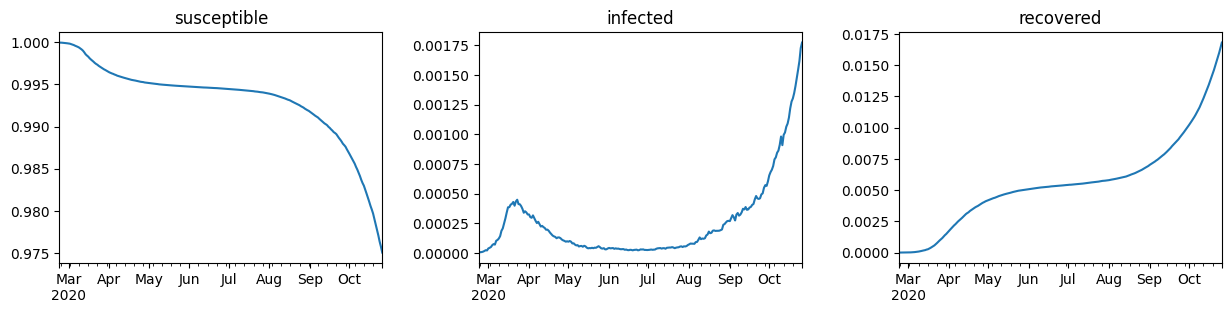

In [103]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 3), gridspec_kw=dict(wspace=0.3))
for idx, col in enumerate(data.columns):
    data[col].plot(ax=axs[idx], title=col)

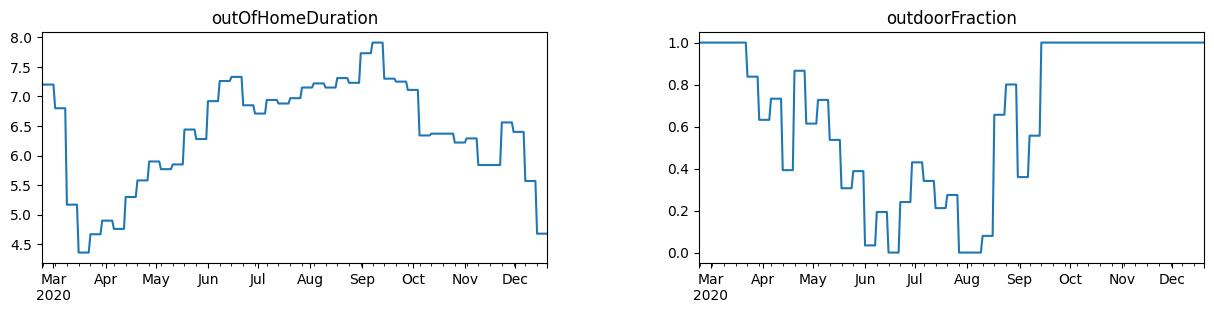

In [104]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 3), gridspec_kw=dict(wspace=0.3))
for idx, col in enumerate(weathermob_df.columns):
    weathermob_df[col].plot(ax=axs[idx], title=col)

In [105]:
# Split into a training and test/prediction set
training_data, test_data = torch.from_numpy(data.values).float()[:233], torch.from_numpy(data.values).float()[233:]
alpha = training_data.sum(dim=0)**(-1)
training_data.shape, test_data.shape, alpha.shape

(torch.Size([233, 3]), torch.Size([14, 3]), torch.Size([3]))

In [106]:
for idx in [0, 2]:  # E, R, Sy, H, C, qS, qE, qI are dropped
    alpha[idx] = 0
alpha

tensor([ 0.0000, 22.1780,  0.0000])

In [107]:
# Define a simple SIR model
def SIR_model(state: torch.Tensor, parameters: dict) -> torch.Tensor:
    new_state = state + torch.stack([- parameters['k_I'] * state[0] * state[1], 
                                      + parameters['k_I'] * state[0] * state[1] - parameters['k_R'] * state[1],
                                      + parameters['k_R'] * state[1]
                                ]) * parameters['dt']
    return new_state

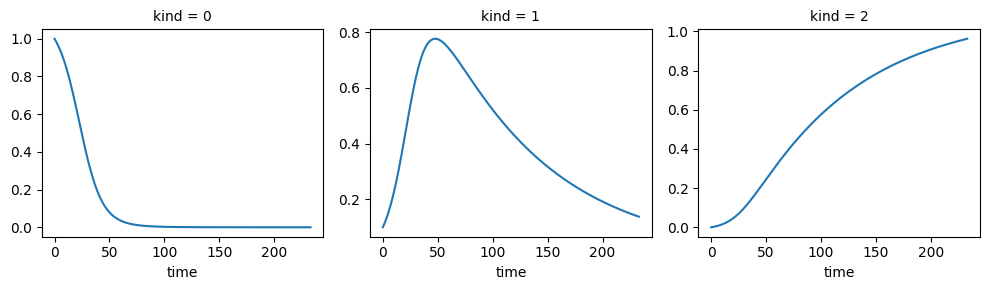

In [108]:
# Small example of the SIR model 
data = [training_data[0] + torch.tensor([0, 0.1, 0])]
for n in range(training_data.shape[0]):
    data.append(SIR_model(data[-1], parameters=dict(k_I=1, k_R=0.1, dt=0.1)))
xr.DataArray(data, dims=["time", "kind"]).plot(col="kind", sharey=False)

In [136]:
# Initialise the neural network
NN = NeuralNet(
    input_size=training_data.shape[1],
    output_size=3, #learn twoo! parameters
    num_layers=5,
    nodes_per_layer=dict(default=20),
    activation_funcs=dict(default='sigmoid', layer_specific={0: 'softplus', -1: 'softplus'}),
    biases=dict(default=[-1, 1]),
    learning_rate=0.0002
)

loss_ts = []

In [137]:
pred_param = []

In [138]:
# Train
n_epochs = 500
batch_size = 10
write_every = 10
parameters = dict(dt=0.1)

for e in (pbar := tqdm.tqdm(range(n_epochs))):
    
    # Run the model, stopping to update the estimates every n steps
    predicted_data = [training_data[0].clone()]
    start_idx = 0
    epoch_loss = []
    _pred_param = []
    
    for t in range(training_data.shape[0]):
        
        predicted_parameters = NN(training_data[t])
        if e % write_every == 0:
            _pred_param.append(predicted_parameters.clone().detach())
        
        # beta = torch.sigmoid((predicted_parameters[0]*weathermob_data[t, 0]**2) - (predicted_parameters[1]*weathermob_data[t, 0]**2)*weathermob_data[t, 1])
        beta = predicted_parameters[0] + weathermob_data[t, 0]*predicted_parameters[1]
        # beta = (predicted_parameters[0]*weathermob_data[t, 0]**2) - (predicted_parameters[1]*weathermob_data[t, 0]**2)*weathermob_data[t, 1]
        predicted_data.append(SIR_model(predicted_data[-1], 
                                        parameters={'k_I': beta[0],
                                                    'k_R': predicted_parameters[2], 
                                                    'dt': torch.tensor(0.1)}))

        if t > 0 and (len(predicted_data) % batch_size == 0):
            
            loss = (
                alpha * ((torch.stack(predicted_data)[1:, :] - training_data[start_idx+1:start_idx+len(predicted_data), :])**2).sum(dim=0)
            ).sum(dim=0)
            loss.backward()
            NN.optimizer.step()
            NN.optimizer.zero_grad()
            start_idx = t
            epoch_loss.append(loss.detach())
            if t < training_data.shape[0] - 1:
                predicted_data = [training_data[t+1].clone()]
    if e % write_every == 0:
        pred_param.append(_pred_param)
    loss_ts.append(np.mean(epoch_loss))
    pbar.set_description(f"Loss: {loss_ts[-1]}")

Loss: 3.738703924227593e-07: 100%|██████████| 500/500 [02:12<00:00,  3.78it/s] 


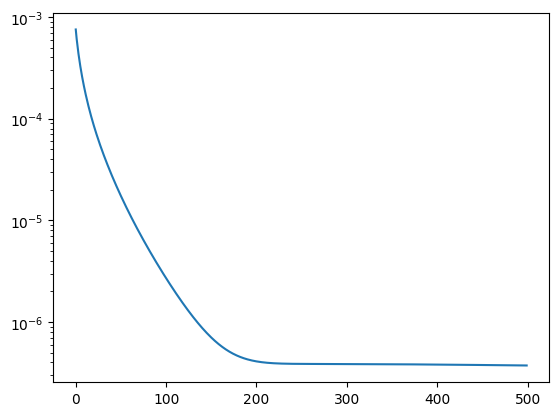

In [139]:
fig, ax = plt.subplots()
ax.plot(loss_ts)
ax.set_yscale('log')

In [140]:
preds = torch.stack([torch.stack(x) for x in pred_param])
preds.shape

torch.Size([50, 233, 3])

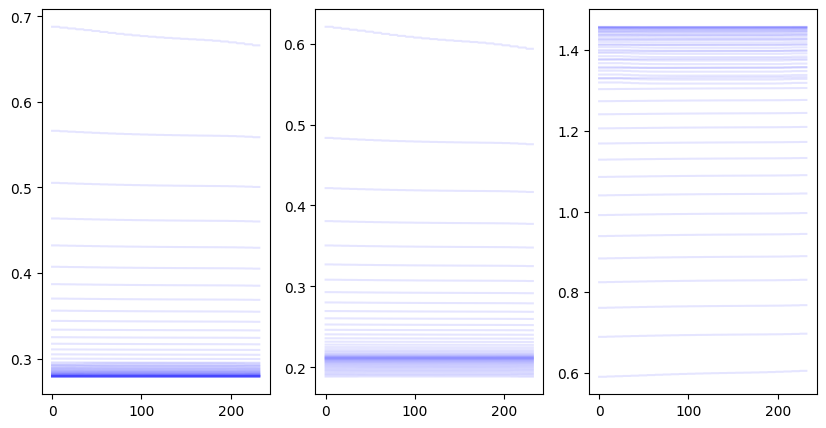

In [141]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 5))
for p in preds:
    for idx, arr in enumerate(p.transpose(0, 1)):
        axs[idx].plot(arr, alpha=0.1, color='blue')

In [142]:
[training_data[0]]

[tensor([9.9998e-01, 3.3570e-06, 2.2380e-06])]

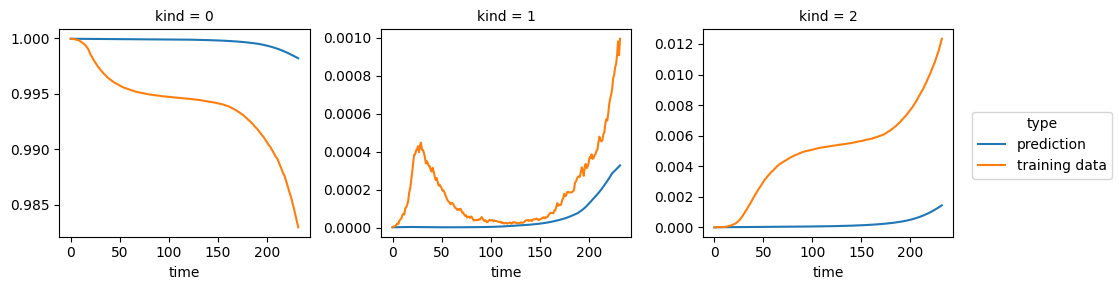

In [143]:
predicted_data = [training_data[0]]
for t in range(training_data.shape[0]):
    
    predicted_parameters = NN(training_data[t]).detach()
    # beta = torch.sigmoid((predicted_parameters[0]*weathermob_data[t, 0]**2) - (predicted_parameters[1]*weathermob_data[t, 0]**2)*weathermob_data[t, 1])
    beta = predicted_parameters[0] + weathermob_data[t, 0]*predicted_parameters[1]
    predicted_data.append(SIR_model(predicted_data[t], 
                                    parameters={'k_I': beta[0], 
                                                'k_R': predicted_parameters[2], 'dt': torch.tensor(0.1)}))
xr.concat([
    xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}), 
    xr.DataArray(training_data, dims=["time", "kind"]).expand_dims({'type': ['training data']})], dim='type').plot(col="kind", hue='type', sharey=False)

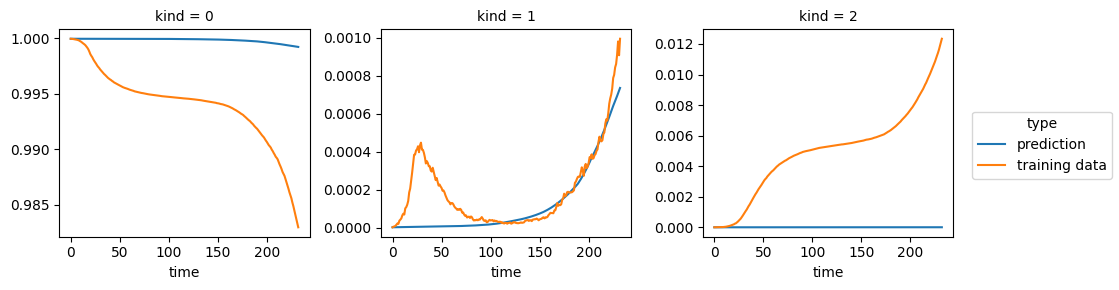

In [215]:
predicted_data = [training_data[0]]
for t in range(training_data.shape[0]):
    
    predicted_parameters = NN(training_data[t]).detach()
    # beta = torch.sigmoid((predicted_parameters[0]*weathermob_data[t, 0]**2) - (predicted_parameters[1]*weathermob_data[t, 0]**2)*weathermob_data[t, 1])
    beta = 0.15*(0.04*(weathermob_data[t, 0]**2) - 0.007*weathermob_data[t, 1]*(weathermob_data[t, 0])**2)
    predicted_data.append(SIR_model(predicted_data[t], 
                                    parameters={'k_I': beta[0], 
                                                'k_R': 0.001, 'dt': torch.tensor(0.1)}))
xr.concat([
    xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}), 
    xr.DataArray(training_data, dims=["time", "kind"]).expand_dims({'type': ['training data']})], dim='type').plot(col="kind", hue='type', sharey=False)

In [204]:
for t in range(training_data.shape[0]):
    beta = 0.024*weathermob_data[t,0]**2 - (0.005*weathermob_data[t,1]*weathermob_data[t, 0]**2)
    print(beta)

tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([12.1824])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([10.8664])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([6.2813])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([4.4673])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.1428])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.6865])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([5.3548])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([6.6865])
tensor([7.3379])

In [67]:
NN(training_data[t])

tensor([4.8106e-03, 7.8599e-05, 2.7032e+00], grad_fn=<SoftplusBackward0>)

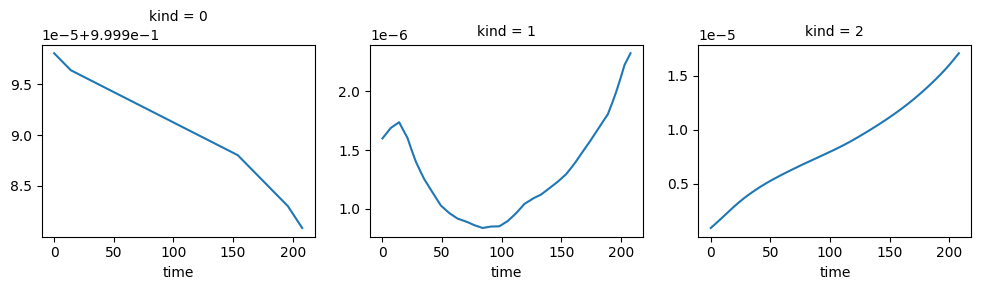

In [31]:
xr.DataArray(predicted_data[1:], dims=["time", "kind"]).expand_dims({'type': ['prediction']}).plot(col="kind", sharey=False)

In [56]:
len(predicted_data)

210

In [216]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Create a toy DataFrame with weather and mobility data
data = {
    'time': np.arange(0, 50, 1),  # Time points
    'weather': np.random.uniform(0.1, 0.9, 50),  # Random weather data (e.g., fraction of good weather)
    'mobility': np.random.uniform(0.5, 1.5, 50)  # Random mobility data (e.g., time spent out of home)
}

df = pd.DataFrame(data)
print(df.head())


   time   weather  mobility
0     0  0.758853  0.664688
1     1  0.289212  0.525703
2     2  0.236241  0.745787
3     3  0.754888  1.146519
4     4  0.864464  1.223223


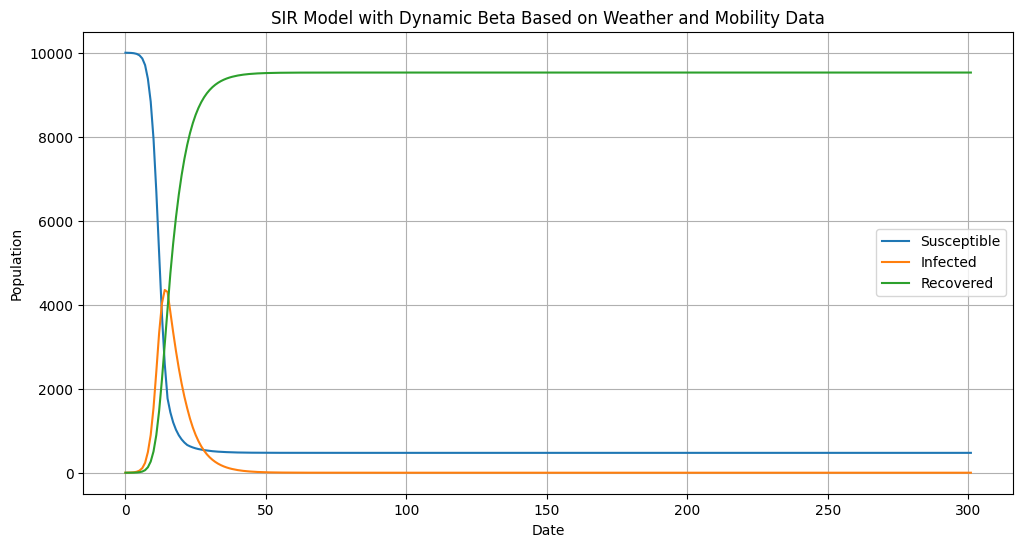

In [231]:
# Define parameters for beta calculation
par1 = 0.024  # Parameter 1 for beta calculation (adjustable)
par2 = 0.005  # Parameter 2 for beta calculation (adjustable)

# Total population, N
N = 10000
# Initial number of infected and recovered individuals, I0 and R0
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# Function to calculate beta based on outOfHomeDuration and outdoorFraction
def calculate_beta(out_of_home_duration, outdoor_fraction, par1, par2):
    # Calculate beta using given parameters and formula
    beta = par1 * out_of_home_duration**2- par2 * outdoor_fraction * out_of_home_duration**2
    return max(beta, 0.001)  # Apply a minimum constraint to avoid negative or zero values

# The SIR model differential equations
def sir_model(y, t, N, par1, par2, df):
    S, I, R = y
    # Find the closest matching index for the current time 't'
    current_index = int(min(t, len(df) - 1))
    current_data = df.iloc[current_index]
    # Calculate beta using current values of outOfHomeDuration and outdoorFraction
    beta = calculate_beta(current_data['outOfHomeDuration'], current_data['outdoorFraction'], par1, par2)
    gamma = 0.2  # Recovery rate, assumed constant

    # SIR model equations
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Time grid corresponding to the length of the data
t = np.arange(len(weathermob_df))

# Integrate the SIR equations over the time grid, t
result = odeint(sir_model, y0, t, args=(N, par1, par2, weathermob_df))

# Extract the results
S, I, R = result.T

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(S, label='Susceptible')
plt.plot(I, label='Infected')
plt.plot(R, label='Recovered')
plt.xlabel('Date')
plt.ylabel('Population')
plt.title('SIR Model with Dynamic Beta Based on Weather and Mobility Data')
plt.legend()
plt.grid()
plt.show()
